In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from tqdm import tqdm
from collections import Counter

# 1. Data

In [3]:
df_incidents = pd.read_csv('peru_incidents.csv')
df_incidents.shape

(1098, 7)

# 2. EDA

In [4]:
pd.DataFrame(df_incidents.company.value_counts()).head(10)

,company
Ripley,92
Claro,22
Telefónica del Perú,21
Colegio Saco Oliveros,16
Técnicas Americanas de Estudio,16
Tottus,14
Telefónica,13
Saga Falabella,10
Interbank,10
Banco del Trabajo,9


In [5]:
pd.DataFrame(df_incidents.location.value_counts()).head(10)

,location
"Lima,Lima",741
"Arequipa,Arequipa",36
"Miraflores,Lima",21
"Surco,Lima",21
"Trujillo,La Libertad",19
"Callao,Callao",16
"Chiclayo,Lambayeque",15
"Piura,Piura",15
"Cusco,Cusco",14
"San Isidro,Lima",13


In [6]:
df_incidents.viewers.describe()

count      1098.000000
mean       6511.188525
std        8761.171861
min         270.000000
25%        2569.500000
50%        4146.500000
75%        7185.250000
max      121206.000000
Name: viewers, dtype: float64

# 3. Pre-procesamiento y keywords

In [7]:
import nltk
import re
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import spacy
stopwords = stopwords.words('spanish')
#spell = SpellChecker(language='es') # Spanish dictionary
#stemmer = SnowballStemmer("spanish")
punctuation = string.punctuation + '¿¡'
nlp = spacy.load("es_core_news_md")

def text_preprocesor(text:str):
    tokens = []
    for w in nlp(text):
        w = w.lemma_.lower()
        if not re.search('[0-9]', w) and not (w in punctuation) and (w not in stopwords): tokens.append(w)
    #tokens = [w if w in spell else spell.correction(w) for w in tokens]
    return ' '.join(tokens)

In [8]:
tqdm.pandas()
df_incidents['text_len'] = df_incidents.text.apply(len) 
df_incidents['text_prep'] = df_incidents.text.progress_apply(text_preprocesor) 
df_incidents['text_prep_len'] = df_incidents.text_prep.apply(len) 

/home/gbustamante/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1098/1098 [00:57<00:00, 19.26it/s]


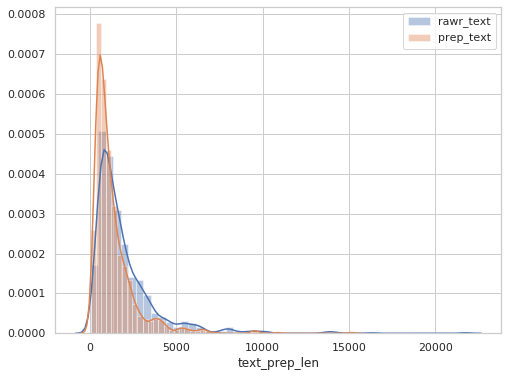

In [9]:
plt.figure(figsize=(8,6))
sns.distplot(df_incidents['text_len'], hist=True, label='rawr_text')
sns.distplot(df_incidents['text_prep_len'], hist=True, label='prep_text')
plt.legend()

In [10]:
df_incidents['text_prep'] = df_incidents['text_prep'].fillna('')

In [11]:
df_comps = pd.DataFrame({'company': df_incidents['company'].value_counts().index,
                       'freq': df_incidents['company'].value_counts().values})
selected_comps = list(df_incidents['company'])
len(selected_comps)

1098

In [12]:
import re
def get_aspects(x):
    doc=nlp(x) ## Tokenize and extract grammatical components
    new_doc = []
    for i in doc:
         ## Remove common words and retain only nouns
        if ((i.text not in stopwords) and (re.search('[a-zA-Z]', i.text)) and (i.pos_=="NOUN")): new_doc.append(i.text)
    return ' '.join(new_doc)

In [14]:
df_incidents['keywords'] = ' '
df_incidents['n_keywords'] = 0

for comp in tqdm(selected_comps):
    comp_reviews = list(df_incidents[df_incidents.company==comp]['text_prep'])
    
    nouns = [get_aspects(r) for r in comp_reviews]
    
    cnt = Counter(' '.join(nouns).split())
    labels, values = zip(*cnt.items())
    df_aspects = pd.DataFrame({'aspect': labels, 'freq': values})
    df_aspects = df_aspects.sort_values(by='freq', ascending=False)
    aspects = list(df_aspects.head(10)['aspect'])
    n_keys = len(aspects)
    aspects = ' '.join(aspects)
    
    df_incidents.loc[df_incidents['company']==comp, 'keywords'] = aspects
    df_incidents.loc[df_incidents['company']==comp, 'n_keywords'] = n_keys

100%|██████████| 1098/1098 [06:02<00:00,  3.03it/s]


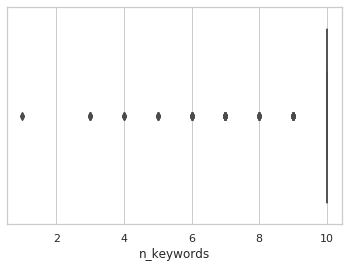

In [15]:
sns.boxplot(df_incidents.n_keywords)

In [16]:
df_incidents[['company', 'keywords']].sample(5)

,company,keywords
394,Nextel,nextel servicio costo manera tecnología veloci...
648,COPA Airlines,paquete respuesta pesar kilo juguete articulos...
1026,Ripley,tarjeta cliente día tiendas gente sol segurida...
698,GOL,aeropuerto hora puerta gol maleta avión chofer...
716,PUCP,selección vez examen sistema suerte miembro am...


**Filtrar y ordenar keywords por sentimiento**

In [20]:
from classifier import *
clf = SentimentClassifier()

df_incidents['sorted_keywords'] = ' '
df_incidents['sorted_nkeywords'] = 0

for keys in df_incidents['keywords'].unique():
    data = []
    for k in keys.split(' '):
        score = clf.predict(k)
        if(score<0.5): data.append((k, score))
    df_aux = pd.DataFrame(data, columns=['key', 'score'])
    df_aux = df_aux.sort_values(by='score', ascending=False)
    
    df_incidents.loc[df_incidents['keywords']==keys, 'sorted_keywords'] = ' '.join(list(df_aux.key))
    df_incidents.loc[df_incidents['keywords']==keys, 'sorted_nkeywords'] = len(df_aux)

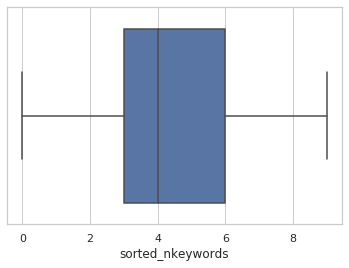

In [21]:
sns.boxplot(df_incidents.sorted_nkeywords)

In [22]:
print(df_incidents[(df_incidents.company=='Ripley')]['keywords'].unique())
print(df_incidents[(df_incidents.company=='Ripley')]['sorted_keywords'].unique())

['tarjeta cliente día tiendas gente sol seguridad mes cuota tiempo']
['tarjeta cuota']


In [23]:
print(df_incidents[(df_incidents.company=='Claro')]['keywords'].unique())
print(df_incidents[(df_incidents.company=='Claro')]['sorted_keywords'].unique())

['servicio sol empresa cliente problema mensaje vez hora velocidad gente']
['hora problema empresa']


In [24]:
print(df_incidents[(df_incidents.company=='Telefónica')]['keywords'].unique())
print(df_incidents[(df_incidents.company=='Telefónica')]['sorted_keywords'].unique())

['servicio sol empresa día dinero tiempo velocidad teléfono año madre']
['madre teléfono empresa dinero']


In [25]:
print(df_incidents[(df_incidents.company=='Interbank')]['keywords'].unique())
print(df_incidents[(df_incidents.company=='Interbank')]['sorted_keywords'].unique())

['tarjeta banco mes año vez banca dólar dinero cajero monedero']
['dólar banca tarjeta banco cajero dinero']
